# Single Model Uses

This notebook shows some uses of the forced baroptric model with singel model runs. See model_ensemble for uses as it pertains to ensembles of runs

In [1]:
# This directive tells the notebook to add interactive plots in the notebook
#%matplotlib widget

from forced_barotropic_sphere.sphere import Sphere #bm3_barotropic_model packages
from forced_barotropic_sphere.solver import Solver
from forced_barotropic_sphere.forcing import Forcing
import forced_barotropic_sphere.plotting as plotters
import forced_barotropic_sphere.ensemble_methods as ensemble_methods
import matplotlib.path as mpath
import forced_barotropic_sphere.parcel_tracking as tracking

import time
import numpy as np
import random
import xarray as xr

import cartopy as crt             # Map projection stuff
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib as mpl          # Plotting routines
import matplotlib.pyplot as plt    
import matplotlib.animation as manim
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm

from IPython.display import display, clear_output, HTML, FileLink  # Some technical stuff, used to display animation

In [2]:
##physical constants
s2d = 1/3600/24    # seconds to days
s2h = 1/3600       # seconds to hours
a = 6371e3         # Radius of the earth in m
g00 = 9.81         # Acceleration due to gravity near the surface of the earth in m/s^2
R = 287.           # Dry gas constant in J/K/kg
d2r = np.pi / 180. # Factor to convert degrees to radians
r2d = 180. / np.pi # Factor to convert radians to degrees


We may simply integrate a single model and plot the resulting output at the final integration step

In [21]:
dt = 1800 #time between integration steps (seconds)
Nt = 2000 #number of integration steps
T= Nt*dt #total integration time
print('integrating for {:.1f} days with a dt of {:.2f} hours'.format(T*s2d,dt*s2h))

ofreq = 6 #frequency of integration output in resulting ds
print('output freq of {:.2f} hours'.format(dt*s2h*ofreq))

M = 63
st = Sphere(M, base_state='held85')

F = Forcing(st,dt,T)
#Si = F.generate_rededdy_start() #initial forcing
#forcing_tseries = F.generate_rededdy_tseries(A=5e-12,Si=Si) #evolve forcing
forcing_tseries = F.generate_zeroforcing_tseries()


k0=3 #if we want to start with some structure in the vorticity here's an option
vortp = 1e-5 * np.exp( -0.5 * (st.glats - 45.)**2 / 10**2 ) * np.cos(k0 * st.rlons)

Pvortp = 1e-5 * np.exp( -0.5 * (st.glats - 45.)**2 / 10**2 -0.5 * (st.glons - 60.)**2 / 10**2 )

#vortp = np.zeros(thetap.shape)
thetap = np.zeros(vortp.shape) #we'll start with t0=background state
st.set_ics([vortp,thetap])

# Turn off frictional dissipation, add viscosity values from Held 1985
params = dict(rs = 0., nu = 1e4, diffusion_order=1, robert_filter=0.01)

# Turn off frictional dissipation, add viscosity values from Held and Phillips 1987
#params = dict(rs = 0., nu = 1e15, diffusion_order=2)

#choose whether we integrate with a linear temp/vorticity field. temp_linear=False uses nonlinear advection
S = Solver(st, forcing=F, ofreq=ofreq, **params)

sln = S.integrate_dynamics(vort_linear=True)

integrating for 41.7 days with a dt of 0.50 hours
output freq of 3.00 hours
integrating with:  nu= 10000.0 diffusion_order= 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 487.90it/s]


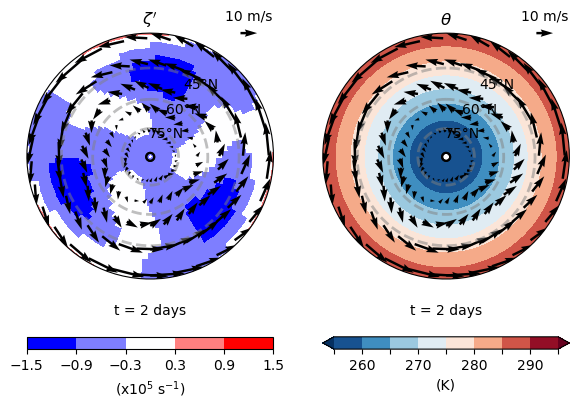

In [22]:
tidx=15
#tidx=int(Nt/ofreq)-1
f,ax = plotters.plot_overview(sln.isel(time=tidx), levels=[np.linspace(-1.5,1.5,6),np.arange(255,300,5)], var=['vortp','theta'])
#f.savefig('./images/L18_singlerun.png',dpi=300, bbox_inches='tight')

array([<Axes: title={'center': 'Perturbation Energy'}, xlabel='time (days)'>,
       <Axes: title={'center': 'Perturbation Enstrophy'}, xlabel='time (days)'>],
      dtype=object)

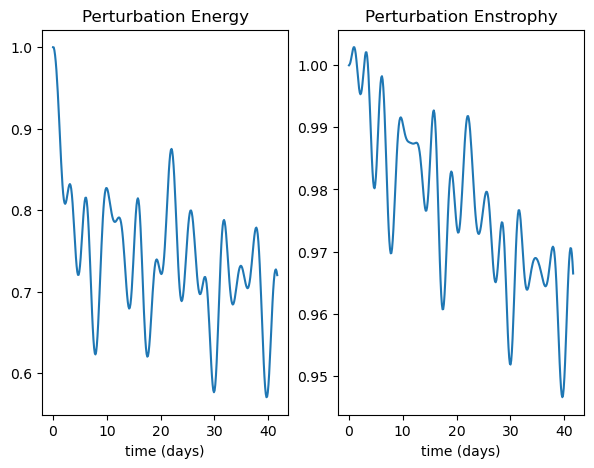

In [23]:
from importlib import reload
reload(plotters)
plotters.plot_energy(sln)


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#careful..this takes quite a while to run. ~4s/frame
starttime = time.time()
plotters.overview_animation(sln, times = [0,T], xs=None, filename = './images/overview_nonlinear_dt3000.gif')
print('time taken to animate: ', time.time()-starttime)

### Tracking parcels
We can use a parcel tracking routine to help show spread growth

In [ ]:
dsr = sln.rename(dict(x='lon',y='lat'))
# Reassign longitude coordinates between -180 and 180E
dsr = dsr.assign_coords(lon=(((dsr.lon + 180) % 360) - 180))
dsr = dsr.sortby('lon')

x0 = [(-100., l) for l in np.linspace(45, 65, 10)] #initial position of parcel
t0=0. #t0=(0,T)
ts, xs = tracking.calculate_trajectories(dsr, x0, t0 = sln.time.isel(time=0).data)


In [ ]:
#plotters.overview_animation(sln, times = [0,T],filename = 'trajectory.gif', xs=xs,ts=ts)